In [3]:
import torch
from torchvision import transforms
from PIL import Image
from models import FaceNetModel
import torch.nn.functional as F

In [4]:
state = torch.load('log/best_state.pth')

In [5]:
state['accuracy']

0.8679500000000001

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
trfrm =transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

In [8]:
img1 = Image.open('/home/khairulimam/datasets/lfw-mtcnn-182/Aaron_Patterson/Aaron_Patterson_0001.jpg')
img2 = Image.open('/home/khairulimam/datasets/lfw-mtcnn-182/Aaron_Eckhart/Aaron_Eckhart_0001.jpg')

timg1 = trfrm(img1).to(device)
timg2 = trfrm(img2).to(device)

In [26]:
img3 = Image.open('/home/khairulimam/datasets/lfw-mtcnn-182/Ariel_Sharon/Ariel_Sharon_0005.jpg')
img4 = Image.open('/home/khairulimam/datasets/lfw-mtcnn-182/Ariel_Sharon/Ariel_Sharon_0077.jpg')

timg3 = trfrm(img3).to(device)
timg4 = trfrm(img4).to(device)

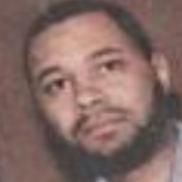

In [10]:
img1

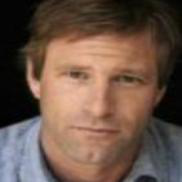

In [11]:
img2

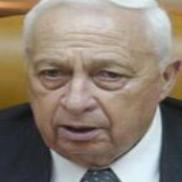

In [27]:
img3

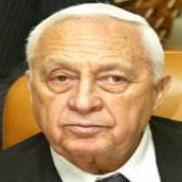

In [28]:
img4

In [20]:
model = FaceNetModel(128, 500, True)
model.load_state_dict(state['state_dict'])

In [21]:
model.to(device)
print("model to device")

model to device


In [22]:
model.eval()
with torch.no_grad():
    embed1 = model(timg1.unsqueeze(0))
    embed2 = model(timg2.unsqueeze(0))

In [29]:
model.eval()
with torch.no_grad():
    embed3 = model(timg3.unsqueeze(0))
    embed4 = model(timg4.unsqueeze(0))

In [30]:
F.pairwise_distance(embed3, embed4)

tensor([0.9643], device='cuda:0')

In [25]:
F.pairwise_distance(embed1, embed2)

tensor([2.5974], device='cuda:0')

In [69]:
embed1, embed2

(tensor([[ 0.3370, -0.3614,  0.8608,  0.5060, -0.1757,  0.5590, -1.8451, -1.2620,
          -1.3749, -0.4498, -0.0875, -0.6536, -0.5108,  0.9045,  0.5060, -0.2994,
          -0.2890, -0.8462, -0.8777, -0.2066, -0.4038, -0.1009,  0.2949,  0.5302,
          -1.3806, -0.2071,  0.2457,  0.5530, -0.4515,  1.1013,  0.0718,  0.4647,
          -0.8914, -0.7401,  1.0403, -0.6823,  0.4697, -1.8642, -0.2048,  0.9089,
           1.1275,  0.7309,  0.5715,  1.5348, -0.4524, -1.1029, -2.3377, -2.2613,
          -0.3379, -0.0372,  0.5871, -0.8593,  0.5390,  0.3849, -0.3817,  0.9467,
           1.6029, -0.5130, -0.4396, -0.3071, -0.1689, -0.7907,  0.1261,  0.5350,
           0.3048,  0.8034, -0.8960,  0.2886,  0.0286, -0.5394, -0.6384, -1.3059,
           0.5573, -0.4699,  0.4800, -1.4510,  1.1153,  0.1617, -0.1188, -1.0996,
           1.1528, -0.1223, -0.5016,  1.0884, -0.2359, -0.2241, -0.4027, -1.2005,
           0.1939,  1.2103, -0.8090,  0.1148, -0.0348, -0.3880, -1.8146,  0.9586,
          -1.097

In [71]:
embed3, embed4

(tensor([[ 0.5832, -0.3662,  1.2455,  0.5881, -0.3613,  0.3677, -2.0945, -1.0332,
          -1.1269, -0.5046,  0.1108, -0.7094, -0.1538,  1.2951,  0.5199, -0.1563,
          -0.2247, -1.0975, -0.6844, -0.5914, -0.6142, -0.1989,  0.4156,  0.0833,
          -0.9641,  0.0826,  0.0706,  0.4475, -0.0317,  1.5021, -0.2583,  0.1558,
          -0.8366, -1.2154,  0.7090, -0.7607,  0.3255, -1.9761, -0.6138,  0.9736,
           0.9962,  1.1704,  0.5852,  1.3250,  0.0640, -1.0750, -2.2131, -2.0342,
          -0.1270, -0.1195,  0.4755, -0.8866,  0.3652,  0.1398, -0.7087,  1.0266,
           1.3239, -0.3869, -0.5013, -0.6545,  0.2318, -0.8586,  0.0708,  0.3888,
           0.4798,  0.8322, -0.8746,  0.1741,  0.2020, -0.1288, -0.7802, -1.4083,
           0.6816, -0.5734,  0.6616, -1.0262,  0.9726,  0.0475, -0.3947, -1.1271,
           1.5725, -0.0691, -0.3037,  0.8516, -0.0779, -0.4297, -0.1893, -1.0701,
           0.1205,  1.2160, -0.7514,  0.1876, -0.0236, -0.6596, -1.6291,  0.9333,
          -1.289